In [3]:
import numpy as np
import xarray as xr
from matplotlib import pyplot as plt
from scipy import stats
import cftime
import Functions_data_analysis as fda
import Functions_load_output as flo
import matplotlib.patches as mpatches
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from matplotlib import colors
import matplotlib.path as mpath
from matplotlib.gridspec import GridSpec
from Datasets import exp_set_dict_warm_order
from scipy.stats import pearsonr

In [4]:
# Load Naughten on_shelf temp data timeseries
naught_dir = '/glade/work/gemmao/Naughten_2022/'
fname = 'MITgcm_AmundsenSeaContinentalShelf_1920-2013_sea_water_potential_temperature_200-700m_PACE'
ens_list = [f'{i:02}' for i in range(1, 21)]
n_ens = len(ens_list)

# get times for plotting all members
ds = xr.open_dataset(naught_dir + fname + ens_list[0] + '.nc')
temp = ds.sea_water_potential_temperature
years = np.arange(1920,2014,1)


In [6]:
ens_ds

<xarray.Dataset>
Dimensions:                          (time: 1128)
Coordinates:
  * time                             (time) object 1920-01-01 00:00:00 ... 20...
Data variables:
    sea_water_potential_temperature  (time) float64 ...
Attributes: (12/23)
    CDI:                           Climate Data Interface version 1.9.4 (http...
    CDO:                           Climate Data Operators version 1.9.4 (http...
    title:                         Amundsen Sea MITgcm model output forced wi...
    summary:                       This dataset provides model output for 20t...
    keywords:                      Antarctica,Amundsen Sea,ocean,ice shelves,...
    Conventions:                   ACDD-1.3
    ...                            ...
    geospatial_vertical_min:       -700.0
    geospatial_vertical_max:       -200.0
    time_coverage_start:           1920-01-01
    time_coverage_end:             2013-12-31
    history:                       Tue Feb  1 14:34:19 2022: ncatted -a stand...
    NCO:                           netCDF Operators version 4.7.5 (Homepage =...

01: 0.50 degC/cent*
02: 0.29 degC/cent*
03: 0.20 degC/cent*
04: 0.16 degC/cent*
05: 0.14 degC/cent*
06: 0.18 degC/cent*
07: 0.42 degC/cent*
08: -0.03 degC/cent
09: 0.14 degC/cent*
10: 0.42 degC/cent*
11: 0.55 degC/cent*
12: 0.56 degC/cent*
13: 0.31 degC/cent*
14: 0.38 degC/cent*
15: 0.79 degC/cent*
16: 0.28 degC/cent*
17: 0.69 degC/cent*
18: 0.27 degC/cent*
19: 0.43 degC/cent*
20: 0.17 degC/cent*
Ensemble mean trend: 0.34254958569447513


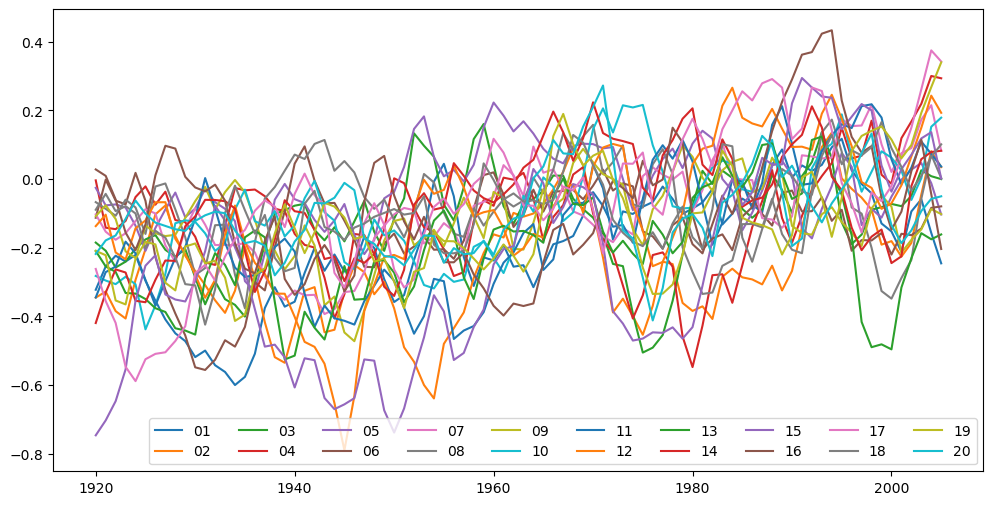

In [7]:
cent_CDW_trends = []
plt.figure(figsize=(12,6))
for i in range(n_ens):
    ens_ds = xr.open_dataset(naught_dir + fname + ens_list[i] + '.nc')
    ens_temp = ens_ds.sea_water_potential_temperature
    ens_temp_ann = ens_temp.resample(time='1Y').mean()
    plt.plot(years,ens_temp_ann,label=ens_list[i])
    # calc trend
    slope, intercept, r_value, p_value, std_err = stats.linregress(years, ens_temp_ann)
    if p_value < 0.05:
        sig = '*'
    else:
        sig = ''
    print(ens_list[i] + ': {:.2f} degC/cent'.format(slope*100)+sig)
    cent_CDW_trends.append(slope*100)
plt.legend(ncol=10)

print('Ensemble mean trend:', np.mean(cent_CDW_trends))

In [8]:
# Get bathyemtry and ice data
region = 'AS_near'
lat1,lat2,lon1,lon2 = fda.plot_regions[region]
land_ice_ds = flo.get_bathymetry_and_troughs()
land_ice_ds = land_ice_ds.sel(lat=slice(lat1,lat2),lon=slice(lon1,lon2))
ice_lons,ice_lats = land_ice_ds.lon, land_ice_ds.lat


In [9]:
# calculate bias-corrected naughten t (for map colors), u, and v trends (for quivers)---------------

# on-shelf temps
ds = xr.open_dataset(naught_dir + 'temp_btw_200_700m.nc')
naught_T_trends = ds.temp_btw_200_700m_trend

# uwinds
ds = xr.open_dataset(naught_dir + 'MITgcm_AmundsenSea_1920-2013_trend_in_eastward_wind_PACE.nc')
naught_uwind_trends = ds['trend_in_eastward_wind'] #shape (20 mems, 384 lats, 600 lons, but dims are labeled "time", "Y", and "X" )
naught_lons,naught_lats = naught_uwind_trends.X, naught_uwind_trends.Y

# vwinds
ds = xr.open_dataset(naught_dir + 'MITgcm_AmundsenSea_1920-2013_trend_in_northward_wind_PACE.nc')
naught_vwind_trends = ds['trend_in_northward_wind'] 


# enter how many members to warm composite 
n_comp_mems = 4

In [10]:
# calculate warm composite----------------------------------

# order members from warmest ens to coolest ens base on CDW trends
indices_descending = sorted(range(len(cent_CDW_trends)), key=lambda i: cent_CDW_trends[i], reverse=True)
warm_ens_idx_list = indices_descending[0:n_comp_mems]
print('warm composite members (member numbers, not indexes):',[i+1 for i in warm_ens_idx_list])

# build composite array
n_lats,n_lons = len(naught_lats), len(naught_lons)
warm_uwind_trend_arr = np.zeros((n_comp_mems,n_lats,n_lons))
warm_vwind_trend_arr = np.zeros((n_comp_mems,n_lats,n_lons))
warm_T_trend_arr = np.zeros((n_comp_mems,n_lats,n_lons))
i = 0
for ens_idx in warm_ens_idx_list:
    print(i)
    warm_uwind_trend_arr[i] = naught_uwind_trends[ens_idx]*100 #from per yr to per cent
    warm_vwind_trend_arr[i] = naught_vwind_trends[ens_idx]*100
    warm_T_trend_arr[i] = naught_T_trends[ens_idx]*100
    i += 1
    
# mean of warm members
warm_naught_uwind_trends = np.mean(warm_uwind_trend_arr, axis = 0)
warm_naught_vwind_trends = np.mean(warm_vwind_trend_arr, axis = 0)
warm_naught_T_trends = np.mean(warm_T_trend_arr, axis = 0)

# get warm comp on-shelf trend
warm_shelf_T_trend = np.mean([cent_CDW_trends[i] for i in warm_ens_idx_list])
print('warm comp. on-shelf T trend:',warm_shelf_T_trend)

warm composite members (member numbers, not indexes): [15, 17, 12, 11]
0
1
2
3
warm comp. on-shelf T trend: 0.6492133974065898


In [11]:
# calculate cool composite----------------------------------

# order plots from warmest ens to coolest ens base on CDW trends
cool_ens_idx_list = indices_descending[-n_comp_mems:] 
print('cool_composite members (member numbers, not indexes):',[i+1 for i in cool_ens_idx_list])

# build composite array
n_lats,n_lons = len(naught_lats), len(naught_lons)
cool_T_trend_arr = np.zeros((n_comp_mems,n_lats,n_lons))
cool_uwind_trend_arr = np.zeros((n_comp_mems,n_lats,n_lons))
cool_vwind_trend_arr = np.zeros((n_comp_mems,n_lats,n_lons))
i = 0
for ens_idx in cool_ens_idx_list:
    print(i)
    cool_T_trend_arr[i] = naught_T_trends[ens_idx]*100 #from per yr to per cent
    cool_uwind_trend_arr[i] = naught_uwind_trends[ens_idx]*100 
    cool_vwind_trend_arr[i] = naught_vwind_trends[ens_idx]*100
    i += 1
    
# mean of cool members
cool_naught_T_trends = np.mean(cool_T_trend_arr, axis = 0)
cool_naught_uwind_trends = np.mean(cool_uwind_trend_arr, axis = 0)
cool_naught_vwind_trends = np.mean(cool_vwind_trend_arr, axis = 0)

# get cool comp on-shelf trend
cool_shelf_T_trend = np.mean([cent_CDW_trends[i] for i in cool_ens_idx_list])
print('cool comp. on-shelf T trend:',cool_shelf_T_trend)

cool_composite members (member numbers, not indexes): [4, 9, 5, 8]
0
1
2
3
cool comp. on-shelf T trend: 0.10238663660888345


In [12]:
# calculate mean of all warm and cool members (em of 20 members is really small)

all_comp_T_trends = np.concatenate((warm_T_trend_arr,cool_T_trend_arr))
all_comp_uwind_trends = np.concatenate((warm_uwind_trend_arr,cool_uwind_trend_arr))
all_comp_vwind_trends = np.concatenate((warm_vwind_trend_arr,cool_vwind_trend_arr))
em_T_trends = np.mean(all_comp_T_trends, axis = 0)
em_uwind_trends = np.mean(all_comp_uwind_trends, axis = 0)
em_vwind_trends = np.mean(all_comp_vwind_trends, axis = 0)

# put warm comp and cool comp trends relative to em trends
warm_anom_naught_T_trends = warm_naught_T_trends - em_T_trends
warm_anom_naught_uwind_trends = warm_naught_uwind_trends - em_uwind_trends
warm_anom_naught_vwind_trends = warm_naught_vwind_trends - em_vwind_trends

cool_anom_naught_T_trends = cool_naught_T_trends - em_T_trends
cool_anom_naught_uwind_trends = cool_naught_uwind_trends - em_uwind_trends
cool_anom_naught_vwind_trends = cool_naught_vwind_trends - em_vwind_trends


In [ ]:
# Plot ens mean trends over full model domain

color_data = [em_T_trends, warm_anom_naught_T_trends, cool_anom_naught_T_trends]
x_data = [em_uwind_trends, warm_anom_naught_uwind_trends, cool_anom_naught_uwind_trends]
y_data = [em_vwind_trends, warm_anom_naught_vwind_trends, cool_anom_naught_vwind_trends]
T_lims = [1,0.4,0.4]
q_scales = [25,1.5,1.5] #bigger scale means smaller arrows
regrids = [12,15,15] # smaller regrid means fewer arrows
titles = ['a) Ensemble Mean', 'b) Warm Composite','c) Cool Composite']

fig = plt.figure()
fig.set_size_inches((5,1.3))
# Create GridSpec with extra columns for colorbars
gs = GridSpec(1, 1, width_ratios=[1], wspace=0.1)

lat1,lat2,lon1,lon2 = fda.plot_regions['full_model_domain']
lon_mid = (lon1+lon2)/2
grid_proj = ccrs.PlateCarree()

axes = []
cf_maps = []
j = 0
for i in range(1):

    if i == 1:
        # empty spot for ens mean colorbar
        ax = fig.add_subplot(gs[0,i])
        ax.set_visible(False)
    else:
        ax = fig.add_subplot(gs[0,i],projection=ccrs.SouthPolarStereo(central_longitude=lon_mid))
        color_data_j = color_data[j]
        x_data_j = x_data[j]
        y_data_j = y_data[j]
    
        #mask large values where ice is 
        warm_color_data_masked = np.where(color_data_j > 1e30, np.ma.masked, color_data_j)
        warm_data_x_masked = np.where(x_data_j > 1e30, np.ma.masked, x_data_j)
        warm_data_y_masked = np.where(y_data_j > 1e30, np.ma.masked, y_data_j)
        cf = ax.pcolormesh(naught_lons, naught_lats, warm_color_data_masked, vmin=-T_lims[j], vmax=T_lims[j],
                           transform=grid_proj, cmap='RdBu_r', zorder=0)
        cf_maps.append(cf)
        quiv = ax.quiver(naught_lons, naught_lats, warm_data_x_masked, warm_data_y_masked, transform = grid_proj, 
                         regrid_shape=regrids[j], pivot = 'middle', scale=q_scales[j], width=0.025, headlength=3,
                         headaxislength=2.5, minshaft=1, edgecolor='white',linewidth = 0.2,zorder=3)
        if i == 0:
            vec_len = 0.4
            ax.quiverkey(quiv, X=-0.04, Y=0.35, U=vec_len, label=str(vec_len)+'\nm/s/cent', 
                         labelpos='S', fontproperties={'size': 5})
        elif i == 3:
            vec_len = 0.2
            ax.quiverkey(quiv, X=-0.04, Y=0.35, U=vec_len, label=str(vec_len)+'\nm/s/cent', 
                         labelpos='S', fontproperties={'size': 5})
        ax.set_title(titles[j], fontsize=8)
        
        j += 1
        axes.append(ax)
        
for ax in axes:
    # Plot bathyemtry and ice and plot
    land_ice_ds = land_ice_ds.sel(lat=slice(lat1,lat2),lon=slice(lon1,lon2))
    lons,lats = land_ice_ds.lon, land_ice_ds.lat
    blevs = (1000,)
    ax.contour(lons,lats,land_ice_ds.bathy,blevs,colors='k',transform=grid_proj,linewidths=1,zorder=1)
    ax.contourf(lons,lats,land_ice_ds.all_ice,transform=grid_proj,colors=['lightgray']*2,alpha=0.6,zorder=2)
    ax.contourf(lons,lats,land_ice_ds.grounded_ice,transform=grid_proj,cmap='binary_r',zorder=2)

    # Set shape of map to match shape of data rather than a rectangle
    rect = mpath.Path([[lon1, lat2], [lon2, lat2],[lon2, lat1], [lon1, lat1], [lon1, lat2]]).interpolated(50)
    proj_to_data = ccrs.PlateCarree()._as_mpl_transform(ax) - ax.transData
    rect_in_target = proj_to_data.transform_path(rect)
    ax.set_boundary(rect_in_target)
    ax.set_xlim(rect_in_target.vertices[:,0].min(), rect_in_target.vertices[:,0].max())
    ax.set_ylim(rect_in_target.vertices[:,1].min(), rect_in_target.vertices[:,1].max())


# Add colorbars
cb_ax1 = fig.add_axes([0.295,0.12,0.02,0.65])
cb1 = fig.colorbar(cf_maps[0], cax=cb_ax1, extend='both',orientation = 'vertical')  
cb1.set_label(label = 'T trend [°C/cent]', fontsize=7)
cb1.ax.tick_params(labelsize=5,pad=0.5)
cb1.set_ticks([-1,0,1])

# cb_ax2 = fig.add_axes([0.9,0.12,0.02,0.65])
# cb2 = fig.colorbar(cf_maps[2], cax=cb_ax2, extend='both',orientation = 'vertical')  
# cb2.set_label(label = 'T trend [°C/cent]', fontsize=7)
# cb2.ax.tick_params(labelsize=5,pad=0.5)
# cb2.set_ticks([-0.4,0,0.4])


fig.subplots_adjust(left=0.05,right=0.88,top=0.9,bottom=0.05,wspace=0.1,hspace=.05)

# plt.savefig('Plots/Figure_5_naught_maps.png',dpi=400)

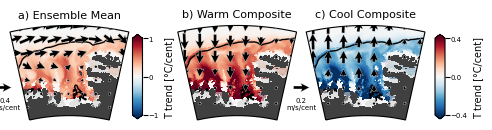

In [61]:
# Plot ens mean trends, warm, and cool composite trend anomalies

color_data = [em_T_trends, warm_anom_naught_T_trends, cool_anom_naught_T_trends]
x_data = [em_uwind_trends, warm_anom_naught_uwind_trends, cool_anom_naught_uwind_trends]
y_data = [em_vwind_trends, warm_anom_naught_vwind_trends, cool_anom_naught_vwind_trends]
T_lims = [1,0.4,0.4]
q_scales = [4,1.5,1.5]
regrids = [17,15,15]
titles = ['a) Ensemble Mean', 'b) Warm Composite','c) Cool Composite']

fig = plt.figure()
fig.set_size_inches((5,1.3))
# Create GridSpec with extra columns for colorbars
gs = GridSpec(1, 4, width_ratios=[1, 0.25, 1, 1], wspace=0.1)

lat1,lat2,lon1,lon2 = fda.plot_regions['AS_near']
lon_mid = (lon1+lon2)/2
grid_proj = ccrs.PlateCarree()

axes = []
cf_maps = []
j = 0
for i in range(4):

    if i == 1:
        # empty spot for ens mean colorbar
        ax = fig.add_subplot(gs[0,i])
        ax.set_visible(False)
    else:
        ax = fig.add_subplot(gs[0,i],projection=ccrs.SouthPolarStereo(central_longitude=lon_mid))
        color_data_j = color_data[j]
        x_data_j = x_data[j]
        y_data_j = y_data[j]
    
        #mask large values where ice is 
        warm_color_data_masked = np.where(color_data_j > 1e30, np.ma.masked, color_data_j)
        warm_data_x_masked = np.where(x_data_j > 1e30, np.ma.masked, x_data_j)
        warm_data_y_masked = np.where(y_data_j > 1e30, np.ma.masked, y_data_j)
        cf = ax.pcolormesh(naught_lons, naught_lats, warm_color_data_masked, vmin=-T_lims[j], vmax=T_lims[j],
                           transform=grid_proj, cmap='RdBu_r', zorder=0)
        cf_maps.append(cf)
        quiv = ax.quiver(naught_lons, naught_lats, warm_data_x_masked, warm_data_y_masked, transform = grid_proj, 
                         regrid_shape=regrids[j], pivot = 'middle', scale=q_scales[j], width=0.025, headlength=3,
                         headaxislength=2.5, minshaft=1, edgecolor='white',linewidth = 0.2,zorder=3)
        if i == 0:
            vec_len = 0.4
            ax.quiverkey(quiv, X=-0.04, Y=0.35, U=vec_len, label=str(vec_len)+'\nm/s/cent', 
                         labelpos='S', fontproperties={'size': 5})
        elif i == 3:
            vec_len = 0.2
            ax.quiverkey(quiv, X=-0.04, Y=0.35, U=vec_len, label=str(vec_len)+'\nm/s/cent', 
                         labelpos='S', fontproperties={'size': 5})
        ax.set_title(titles[j], fontsize=8)
        
        j += 1
        axes.append(ax)
        
for ax in axes:
    # Plot bathyemtry and ice and plot
    land_ice_ds = land_ice_ds.sel(lat=slice(lat1,lat2),lon=slice(lon1,lon2))
    lons,lats = land_ice_ds.lon, land_ice_ds.lat
    blevs = (1000,)
    ax.contour(lons,lats,land_ice_ds.bathy,blevs,colors='k',transform=grid_proj,linewidths=1,zorder=1)
    ax.contourf(lons,lats,land_ice_ds.all_ice,transform=grid_proj,colors=['lightgray']*2,alpha=0.6,zorder=2)
    ax.contourf(lons,lats,land_ice_ds.grounded_ice,transform=grid_proj,cmap='binary_r',zorder=2)

    # Set shape of map to match shape of data rather than a rectangle
    rect = mpath.Path([[lon1, lat2], [lon2, lat2],[lon2, lat1], [lon1, lat1], [lon1, lat2]]).interpolated(50)
    proj_to_data = ccrs.PlateCarree()._as_mpl_transform(ax) - ax.transData
    rect_in_target = proj_to_data.transform_path(rect)
    ax.set_boundary(rect_in_target)
    ax.set_xlim(rect_in_target.vertices[:,0].min(), rect_in_target.vertices[:,0].max())
    ax.set_ylim(rect_in_target.vertices[:,1].min(), rect_in_target.vertices[:,1].max())


# Add colorbars
cb_ax1 = fig.add_axes([0.295,0.12,0.02,0.65])
cb1 = fig.colorbar(cf_maps[0], cax=cb_ax1, extend='both',orientation = 'vertical')  
cb1.set_label(label = 'T trend [°C/cent]', fontsize=7)
cb1.ax.tick_params(labelsize=5,pad=0.5)
cb1.set_ticks([-1,0,1])

cb_ax2 = fig.add_axes([0.9,0.12,0.02,0.65])
cb2 = fig.colorbar(cf_maps[2], cax=cb_ax2, extend='both',orientation = 'vertical')  
cb2.set_label(label = 'T trend [°C/cent]', fontsize=7)
cb2.ax.tick_params(labelsize=5,pad=0.5)
cb2.set_ticks([-0.4,0,0.4])


fig.subplots_adjust(left=0.05,right=0.88,top=0.9,bottom=0.05,wspace=0.1,hspace=.05)

# plt.savefig('Plots/Figure_5_naught_maps.png',dpi=400)

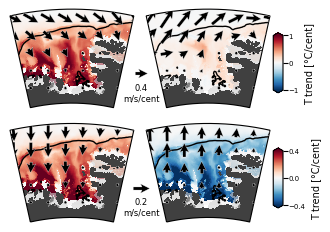

In [62]:
# Plot warm and cool composite trends and trend anomalies

color_data = [warm_naught_T_trends, cool_naught_T_trends, warm_anom_naught_T_trends, cool_anom_naught_T_trends]
x_data = [warm_naught_uwind_trends, cool_naught_uwind_trends, warm_anom_naught_uwind_trends, cool_anom_naught_uwind_trends]
y_data = [warm_naught_vwind_trends, cool_naught_vwind_trends, warm_anom_naught_vwind_trends, cool_anom_naught_vwind_trends]
T_lims = [1,1,0.4,0.4]
q_scales = [4,4,1.5,1.5]

fig = plt.figure()
fig.set_size_inches((3.25,2.4))

lat1,lat2,lon1,lon2 = fda.plot_regions['AS_near']
lon_mid = (lon1+lon2)/2
grid_proj = ccrs.PlateCarree()

axes = []
cf_maps = []
for i in range(4):
    
    ax = fig.add_subplot(2,2,i+1,projection=ccrs.SouthPolarStereo(central_longitude=lon_mid))
    axes.append(ax)

    color_data_i = color_data[i]
    x_data_i = x_data[i]
    y_data_i = y_data[i]

    #mask large values where ice is 
    warm_color_data_masked = np.where(color_data_i > 1e30, np.ma.masked, color_data_i)
    warm_data_x_masked = np.where(x_data_i > 1e30, np.ma.masked, x_data_i)
    warm_data_y_masked = np.where(y_data_i > 1e30, np.ma.masked, y_data_i)
    cf = ax.pcolormesh(naught_lons, naught_lats, warm_color_data_masked, vmin=-T_lims[i], vmax=T_lims[i],
                       transform=grid_proj, cmap='RdBu_r', zorder=0)
    cf_maps.append(cf)
    quiv = ax.quiver(naught_lons, naught_lats, warm_data_x_masked, warm_data_y_masked, transform = grid_proj, 
                     regrid_shape=14, pivot = 'middle', scale=q_scales[i], width=0.025, headlength=3,
                     headaxislength=2.5, minshaft=1, edgecolor='white',linewidth = 0.2,zorder=3)
    if i == 1:
        vec_len = 0.4
        ax.quiverkey(quiv, X=-0.04, Y=0.35, U=vec_len, label=str(vec_len)+'\nm/s/cent', 
                     labelpos='S', fontproperties={'size': 6})
    elif i == 3:
        vec_len = 0.2
        ax.quiverkey(quiv, X=-0.04, Y=0.35, U=vec_len, label=str(vec_len)+'\nm/s/cent', 
                     labelpos='S', fontproperties={'size': 6})
        
for ax in axes:
    # Plot bathyemtry and ice and plot
    land_ice_ds = land_ice_ds.sel(lat=slice(lat1,lat2),lon=slice(lon1,lon2))
    lons,lats = land_ice_ds.lon, land_ice_ds.lat
    blevs = (1000,)
    ax.contour(lons,lats,land_ice_ds.bathy,blevs,colors='k',transform=grid_proj,linewidths=1,zorder=1)
    ax.contourf(lons,lats,land_ice_ds.all_ice,transform=grid_proj,colors=['lightgray']*2,alpha=0.6,zorder=2)
    ax.contourf(lons,lats,land_ice_ds.grounded_ice,transform=grid_proj,cmap='binary_r',zorder=2)

    # Set shape of map to match shape of data rather than a rectangle
    rect = mpath.Path([[lon1, lat2], [lon2, lat2],[lon2, lat1], [lon1, lat1], [lon1, lat2]]).interpolated(50)
    proj_to_data = ccrs.PlateCarree()._as_mpl_transform(ax) - ax.transData
    rect_in_target = proj_to_data.transform_path(rect)
    ax.set_boundary(rect_in_target)
    ax.set_xlim(rect_in_target.vertices[:,0].min(), rect_in_target.vertices[:,0].max())
    ax.set_ylim(rect_in_target.vertices[:,1].min(), rect_in_target.vertices[:,1].max())

# Add colorbars
cb_ax1 = fig.add_axes([0.83,0.58,0.03,0.25])
cb1 = fig.colorbar(cf_maps[1], cax=cb_ax1, extend='both',orientation = 'vertical')  
cb1.set_label(label = 'T trend [°C/cent]', fontsize=7)
cb1.ax.tick_params(labelsize=5,pad=0.5)
cb1.set_ticks([-1,0,1])

cb_ax3 = fig.add_axes([0.83,0.1,0.03,0.25])
cb3 = fig.colorbar(cf_maps[3], cax=cb_ax3, extend='both',orientation = 'vertical')  
cb3.set_label(label = 'T trend [°C/cent]', fontsize=7)
cb3.ax.tick_params(labelsize=5,pad=0.5)
cb3.set_ticks([-0.4,0,0.4])


fig.subplots_adjust(left=0.02,right=0.82,top=0.95,bottom=0.02,wspace=0.1,hspace=.05)

# plt.savefig('Plots/Figure_4_naught_maps.png',dpi=400)

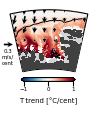

In [14]:
# Plot difference in warm vs cool composites from naughten
naught_uwind_diff = warm_naught_uwind_trends - cool_naught_uwind_trends
naught_vwind_diff = warm_naught_vwind_trends - cool_naught_vwind_trends
naught_T_diff = warm_naught_T_trends - cool_naught_T_trends

lat1,lat2,lon1,lon2 = fda.plot_regions['AS_near']
lon_mid = (lon1+lon2)/2
grid_proj = ccrs.PlateCarree()
Tlim = 1

fig = plt.figure()
fig.set_size_inches((0.9,1.1))
ax = fig.add_subplot(1,1,1,projection=ccrs.SouthPolarStereo(central_longitude=lon_mid))

#mask large values where ice is 
naught_T_diff_masked = np.where(naught_T_diff > 1e30, np.ma.masked, naught_T_diff)
# not necessary for wind bc data provided is only over the ocean

# Plot data
cf = ax.pcolormesh(naught_lons, naught_lats, naught_T_diff_masked, vmin=-Tlim, vmax=Tlim,
                   transform=grid_proj, cmap='RdBu_r', zorder=0)
quiv = ax.quiver(naught_lons, naught_lats, naught_uwind_diff, naught_vwind_diff, transform = grid_proj, 
                 regrid_shape=15, pivot = 'middle', scale=2.5, width=0.025, headlength=3,
                 headaxislength=2.5, minshaft=1, edgecolor='white',linewidth = 0.2,zorder=3)
vec_len = 0.3
ax.quiverkey(quiv, X=-0.03, Y=0.45, U=vec_len, label=str(vec_len)+'\nm/s/\ncent', 
             labelpos='S', fontproperties={'size': 4},labelsep=0.05)

# Plot bathyemtry and ice and plot
land_ice_ds = land_ice_ds.sel(lat=slice(lat1,lat2),lon=slice(lon1,lon2))
lons,lats = land_ice_ds.lon, land_ice_ds.lat
blevs = (1000,)
ax.contour(lons,lats,land_ice_ds.bathy,blevs,colors='k',transform=grid_proj,linewidths=0.7,zorder=2)
ax.contourf(lons,lats,land_ice_ds.all_ice,transform=grid_proj,colors=['lightgray']*2,alpha=1,zorder=4)
ax.contourf(lons,lats,land_ice_ds.grounded_ice,transform=grid_proj,cmap='binary_r',zorder=4)

# Set shape of map to match shape of data rather than a rectangle
rect = mpath.Path([[lon1, lat2], [lon2, lat2],[lon2, lat1], [lon1, lat1], [lon1, lat2]]).interpolated(50)
proj_to_data = ccrs.PlateCarree()._as_mpl_transform(ax) - ax.transData
rect_in_target = proj_to_data.transform_path(rect)
ax.set_boundary(rect_in_target)
ax.set_xlim(rect_in_target.vertices[:,0].min(), rect_in_target.vertices[:,0].max())
ax.set_ylim(rect_in_target.vertices[:,1].min(), rect_in_target.vertices[:,1].max())

# Add colorbar
cb_ax1 = fig.add_axes([0.25,0.25,0.6,0.035])
cb1 = fig.colorbar(cf, cax=cb_ax1, extend='both',orientation = 'horizontal')  
cb1.set_label(label = 'T trend [°C/cent]', fontsize=5)
cb1.ax.tick_params(labelsize=4,pad=0.5)
cb1.set_ticks([-Tlim,0,Tlim])

fig.subplots_adjust(top=0.99,bottom=0.25,right=0.99)

# plt.savefig('Plots/Figure_5_naught_diff_map.png',dpi=600)

In [13]:
# Get data for difference in 5-yr experiment composites

data_dir = 'Saved Arrays/Ensemble_data/'
vnames = ['uwind','vwind','T'] #'T' or 'atemp' works #this indexing is important. don't change.
f_vnames = ['uwind','vwind','T_400m']
da_list = [] #propagate data in order of vnames
exp_set = 'ic_2001' #all forcings are same regardless of exp set

for vname, f_vname in zip(vnames, f_vnames):
    fname = data_dir + f_vname + '_'+exp_set+'_full_model_domain_60_months.nc'
    print(vname, fname)
    ds = xr.open_dataset(fname)
    da = ds[vname]
    print(fname, 'found')
    da_list.append(da)

# Select year-mean and select plotting region--------------------------------

# average over all 5 years
plot_region = 'AS_near'
lat1,lat2,lon1,lon2 = fda.plot_regions[plot_region]
da_list_5yr_mean = [] #follows vname order
for i in range(3):
    da = da_list[i]
    da_5yr_mean = da.mean(dim='time')
    da_reg = da_5yr_mean.sel(lat = slice(lat1, lat2), lon = slice(lon1, lon2))
    da_list_5yr_mean.append(da_reg)

lons,lats = da_reg.lon, da_reg.lat

uwind_mean, vwind_mean, T_mean = da_list_5yr_mean
#Calculate composites
warm_comp_T_runs = T_mean.isel(run = slice(0,4))
warm_comp_T = warm_comp_T_runs.mean(dim='run')
warm_comp_uwind_runs = uwind_mean.isel(run=slice(0,4))
warm_comp_uwind = warm_comp_uwind_runs.mean(dim='run')
warm_comp_vwind_runs = vwind_mean.isel(run=slice(0,4))
warm_comp_vwind = warm_comp_vwind_runs.mean(dim='run')
print('warm composite runs:',warm_comp_T_runs.run.values)

cool_comp_T_runs = T_mean.isel(run = slice(4,8))
cool_comp_T = cool_comp_T_runs.mean(dim='run')
cool_comp_uwind_runs = uwind_mean.isel(run=slice(4,8))
cool_comp_uwind = cool_comp_uwind_runs.mean(dim='run')
cool_comp_vwind_runs = vwind_mean.isel(run=slice(4,8))
cool_comp_vwind = cool_comp_vwind_runs.mean(dim='run')
print('cool composite runs:',cool_comp_T_runs.run.values)

# Get composite diffs in 5-yr-means
uwind_diff = warm_comp_uwind - cool_comp_uwind
vwind_diff = warm_comp_vwind - cool_comp_vwind
T_diff = warm_comp_T - cool_comp_T

uwind Saved Arrays/Ensemble_data/uwind_ic_2001_full_model_domain_60_months.nc
Saved Arrays/Ensemble_data/uwind_ic_2001_full_model_domain_60_months.nc found
vwind Saved Arrays/Ensemble_data/vwind_ic_2001_full_model_domain_60_months.nc
Saved Arrays/Ensemble_data/vwind_ic_2001_full_model_domain_60_months.nc found
T Saved Arrays/Ensemble_data/T_400m_ic_2001_full_model_domain_60_months.nc
Saved Arrays/Ensemble_data/T_400m_ic_2001_full_model_domain_60_months.nc found
warm composite runs: ['run_forc_erai_1982_rep_ic_2001' 'run_forc_erai_1984_rep_ic_2001'
 'run_forc_erai_1989_rep_ic_2001' 'run_forc_erai_1992_rep_ic_2001']
cool composite runs: ['run_forc_erai_1994_rep_ic_2001' 'run_forc_erai_2003_rep_ic_2001'
 'run_forc_erai_2009_rep_ic_2001' 'run_forc_erai_1991_rep_ic_2001']


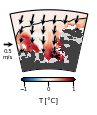

In [50]:
# Plot difference in warm vs cool composites from 5-yr experiments

lat1,lat2,lon1,lon2 = fda.plot_regions['AS_near']
lon_mid = (lon1+lon2)/2
grid_proj = ccrs.PlateCarree()
Tlim = 1

fig = plt.figure()
fig.set_size_inches((0.9,1.1))
ax = fig.add_subplot(1,1,1,projection=ccrs.SouthPolarStereo(central_longitude=lon_mid))

# Plot data
cf = ax.pcolormesh(lons, lats, T_diff, vmin=-Tlim, vmax=Tlim,
                   transform=grid_proj, cmap='RdBu_r', zorder=0)
# mask data over land to match naughten
uwind_diff_masked = np.where(land_ice_ds.all_ice == 1, np.ma.masked, uwind_diff)
vwind_diff_masked = np.where(land_ice_ds.all_ice == 1, np.ma.masked, vwind_diff)

quiv = ax.quiver(lons, lats, uwind_diff_masked, vwind_diff_masked, transform = grid_proj, 
                 regrid_shape=7.7, pivot = 'middle', scale=4, width=0.025, headlength=3,
                 headaxislength=2.5, minshaft=1, edgecolor='white',linewidth = 0.2,zorder=3)
vec_len = 0.5
ax.quiverkey(quiv, X=-0.03, Y=0.45, U=vec_len, label=str(vec_len)+'\nm/s', 
             labelpos='S', fontproperties={'size': 4},labelsep=0.05)

# Plot bathyemtry and ice and plot
land_ice_ds = land_ice_ds.sel(lat=slice(lat1,lat2),lon=slice(lon1,lon2))
lons,lats = land_ice_ds.lon, land_ice_ds.lat
blevs = (1000,)
ax.contour(lons,lats,land_ice_ds.bathy,blevs,colors='k',transform=grid_proj,linewidths=0.7,zorder=2)
ax.contourf(lons,lats,land_ice_ds.all_ice,transform=grid_proj,colors=['lightgray']*2,alpha=1,zorder=4)
ax.contourf(lons,lats,land_ice_ds.grounded_ice,transform=grid_proj,cmap='binary_r',zorder=4)

# Set shape of map to match shape of data rather than a rectangle
rect = mpath.Path([[lon1, lat2], [lon2, lat2],[lon2, lat1], [lon1, lat1], [lon1, lat2]]).interpolated(50)
proj_to_data = ccrs.PlateCarree()._as_mpl_transform(ax) - ax.transData
rect_in_target = proj_to_data.transform_path(rect)
ax.set_boundary(rect_in_target)
ax.set_xlim(rect_in_target.vertices[:,0].min(), rect_in_target.vertices[:,0].max())
ax.set_ylim(rect_in_target.vertices[:,1].min(), rect_in_target.vertices[:,1].max())

# Add colorbar
cb_ax1 = fig.add_axes([0.25,0.25,0.6,0.035])
cb1 = fig.colorbar(cf, cax=cb_ax1, extend='both',orientation = 'horizontal')  
cb1.set_label(label = 'T [°C]', fontsize=5)
cb1.ax.tick_params(labelsize=4,pad=0.5)
cb1.set_ticks([-Tlim,0,Tlim])

fig.subplots_adjust(top=0.99,bottom=0.25,right=0.99)

# plt.savefig('Plots/Figure_5c_5yr_exp_diff_map.png',dpi=600)

In [15]:
# calculate shelf-break zonal wind trend in each member
# mask invalid values (really large values are model bounds)
naught_uwind_masked = naught_uwind_trends.where(naught_uwind_trends < 1e30)
naught_vwind_masked = naught_vwind_trends.where(naught_vwind_trends < 1e30)

sb_uwind_trends = [] #ordered from warmest to coolest warming trends
shelf_vwind_trends = []
cent_CDW_trends_ordered = []
for i in range(20):

    ens_i = indices_descending[i] #starts from warmest members
    # get sb_uwind trends
    sb_uwind_reg = naught_uwind_masked[ens_i].sel(X=slice(-115,-102),Y=slice(-72,-70))
    sb_uwind_y_avg = sb_uwind_reg.mean(dim='Y')
    sb_uwind = sb_uwind_y_avg.mean(dim='X')*100 #put in per/cent
    sb_uwind_trends.append(sb_uwind)

    # get on-shelf vwind trends
    shelf_vwind_reg = naught_vwind_masked[ens_i].sel(X=slice(-115,-100),Y=slice(-76,-70))
    shelf_vwind_y_avg = shelf_vwind_reg.mean(dim='Y')
    shelf_vwind = shelf_vwind_y_avg.mean(dim='X')*100 #put in per/cent
    shelf_vwind_trends.append(shelf_vwind)

    cent_CDW_trends_ordered.append(cent_CDW_trends[ens_i])
    print('Ens '+str(ens_i+1)+' shelf-break trend: {:.2f}'.format(sb_uwind)+', Shelf vwind trend: {:.2f}'.format(shelf_vwind)+', CDW trend: {:.2f}'.format(cent_CDW_trends[ens_i]))
    

Ens 15 shelf-break trend: 0.25, Shelf vwind trend: -0.13, CDW trend: 0.79
Ens 17 shelf-break trend: 0.52, Shelf vwind trend: -0.18, CDW trend: 0.69
Ens 12 shelf-break trend: 0.38, Shelf vwind trend: -0.02, CDW trend: 0.56
Ens 11 shelf-break trend: 0.57, Shelf vwind trend: -0.06, CDW trend: 0.55
Ens 1 shelf-break trend: 0.52, Shelf vwind trend: -0.03, CDW trend: 0.50
Ens 19 shelf-break trend: 0.75, Shelf vwind trend: -0.03, CDW trend: 0.43
Ens 7 shelf-break trend: 0.22, Shelf vwind trend: 0.08, CDW trend: 0.42
Ens 10 shelf-break trend: 0.92, Shelf vwind trend: -0.23, CDW trend: 0.42
Ens 14 shelf-break trend: 0.81, Shelf vwind trend: -0.28, CDW trend: 0.38
Ens 13 shelf-break trend: 0.67, Shelf vwind trend: -0.06, CDW trend: 0.31
Ens 2 shelf-break trend: 0.28, Shelf vwind trend: -0.03, CDW trend: 0.29
Ens 16 shelf-break trend: 0.29, Shelf vwind trend: -0.22, CDW trend: 0.28
Ens 18 shelf-break trend: 0.51, Shelf vwind trend: -0.10, CDW trend: 0.27
Ens 3 shelf-break trend: 0.64, Shelf vwind

In [16]:
# Load reconstruction trends
# Get recon data with anom ref 1979-2005

recon_dir = 'Climate_Data/LMR_output/'
# pace_recon = 'PACE_super_GKO1_all_linPSM_1mc_1900_2005_GISBrom_1880_2019_v10_sst'
pace2_recon = 'PAC_PACE2_super_GKO1_all_bilinPSM_1mc_1850_2005_GISBrom'
lme_recon = 'iCESM_LME_GKO1_linPSM_1mc_1800_2005_v10'
lens2_recon='LENS2_super_GKO1_all_bilinPSM_1mc_1850_2005_GISBrom'

recons = [lme_recon, lens2_recon, pace2_recon]
labs = ['CESM1-LME recon','CESM2-LENS recon','CESM2-PACE recon']


def get_recon_trends(recon,vname,region,time_per):
    """
    Gets gridded recon data from 1900 to 2005 in anomalies relative to 1979-2005.
    """
    region_dict = {'shelf_break':[-72,-70,-115,-102],'ase':[-76,-70,-115,-100]}
    lat1,lat2,lon1,lon2 = region_dict[region]
    lon1,lon2 = lon1+360, lon2+360
    
    recon_ds = xr.open_dataset(recon_dir+recon+'_'+vname+'.nc')
    recon_data = recon_ds.get(vname)
    recon_reg_data = recon_data.sel(lat = slice(lat1,lat2),lon = slice(lon1,lon2),
                                   time = slice(time_per[0],time_per[1]))
    # print(recon_reg_data.lat.values,recon_reg_data.lon.values)
    
    recon_reg_data = recon_reg_data.squeeze()
    recon_tseries = recon_reg_data.mean(dim='lat')
    recon_tseries = recon_tseries.mean(dim='lon')
    
    years = recon_reg_data.time
    slope, intercept, r_value, p_value, std_err = stats.linregress(years, recon_tseries)
    recon_trend = slope*100
    
    return recon_trend


recon_sb_u10_trends = []
recon_ase_v10_trends = []

for recon,lab in zip(recons, labs):
    
    recon_u10_trend = get_recon_trends(recon, 'u10','shelf_break',[1920,2005])
    recon_sb_u10_trends.append(recon_u10_trend)

    recon_v10_trend = get_recon_trends(recon, 'v10','ase',[1920,2005])
    recon_ase_v10_trends.append(recon_v10_trend)
    
print(recon_sb_u10_trends)
print(recon_ase_v10_trends)

[-0.7889893976512417, 0.5527001231047021, 0.06439889075403325]
[-0.31567931171014424, -0.5899221873699619, -0.3022920126058951]


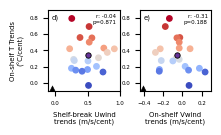

In [17]:
colors = np.linspace(0, 1, 20)
fs = 5

fig = plt.figure()
fig.set_size_inches(2.2,1.2)

# Plot uwinds
ax = fig.add_subplot(1,2,1)
s0 = ax.scatter(sb_uwind_trends, cent_CDW_trends_ordered, c=colors, cmap='coolwarm_r', s=15)
r0, p_value0 = pearsonr(sb_uwind_trends, cent_CDW_trends_ordered)
ax.text(0.95, 0.95, 'r: {:.2f}'.format(r0)+'\np={:.3f}'.format(p_value0), transform=ax.transAxes,
        fontsize=fs-1, verticalalignment='top', horizontalalignment='right')
# Plot ens mean
s1 = ax.scatter(np.mean(sb_uwind_trends),np.mean(cent_CDW_trends),edgecolor='k',linewidth=0.6,facecolor='rebeccapurple',s=15)
# Plot recon trends
s2 = ax.scatter(np.mean(recon_sb_u10_trends),[-0.06,],edgecolor='k',linewidth=0.3,facecolor='k',s=15,marker="^")

# Plot vwinds
ax1 = fig.add_subplot(1,2,2)
s3 = ax1.scatter(shelf_vwind_trends, cent_CDW_trends_ordered, c=colors, cmap='coolwarm_r', s=15)
r1, p_value1 = pearsonr(shelf_vwind_trends, cent_CDW_trends_ordered)
ax1.text(0.95, 0.95, 'r: {:.2f}'.format(r1)+'\np={:.3f}'.format(p_value1), transform=ax1.transAxes,
        fontsize=fs-1, verticalalignment='top', horizontalalignment='right')
# Plot ens mean
s4 = ax1.scatter(np.mean(shelf_vwind_trends),np.mean(cent_CDW_trends),edgecolor='k',linewidth=0.6,facecolor='rebeccapurple',s=15)
# Plot recon trends
s5 = ax1.scatter(np.mean(recon_ase_v10_trends),[-0.06,],edgecolor='k',linewidth=0.3,facecolor='k',s=15,marker="^")


# format
ax.set_xlabel('Shelf-break Uwind\ntrends (m/s/cent)',fontsize=fs)
ax.set_ylabel('On-shelf T Trends\n(°C/cent)',fontsize=fs)
ax1.set_xlabel('On-shelf Vwind\ntrends (m/s/cent)',fontsize=fs)
ax.set_xlim([-0.11,1])
ax1.set_xlim([-0.44,0.3])
# Add subplot labels
ax.text(0.15, 0.95, 'd)', transform=ax.transAxes,
        fontsize=fs, verticalalignment='top', horizontalalignment='right')
ax1.text(0.15, 0.95, 'e)', transform=ax1.transAxes,
        fontsize=fs, verticalalignment='top', horizontalalignment='right')
for ax in [ax,ax1]:
    ax.tick_params(axis='both', which='major', labelsize=fs-1)
    ax.tick_params(axis='both', which='minor', labelsize=fs-1)
    ax.set_ylim([-0.1,0.9])
fig.subplots_adjust(wspace=0.28,left=0.2,bottom=0.3,top=0.98,right=0.94)

# plt.savefig('Plots/Figure_5x_Naughten_scatter.png',dpi=600)

In [80]:
# Do same comparison for your experiments

# Calc 5-yr-mean on-shelf T, shelf-break uwind, ASE-vwind
ens_sb_uwind = []
ens_shelf_vwind = []
ens_shelf_T = [] # list of vals for each ens member
for ens_i in range(10):

    # get mean sb_uwinds
    sb_uwind_reg = da_list[0][ens_i].sel(lon=slice(-115,-102),lat=slice(-70,-72))
    sb_uwind_lon_avg = sb_uwind_reg.mean(dim='lon')
    sb_uwind_tseries = sb_uwind_lon_avg.mean(dim='lat')
    sb_uwind = sb_uwind_tseries.mean()
    ens_sb_uwind.append(float(sb_uwind))

    # get mean ASE vwinds
    shelf_vwind_reg = da_list[1][ens_i].sel(lon=slice(-115,-100),lat=slice(-70,-76))
    shelf_vwind_lon_avg = shelf_vwind_reg.mean(dim='lon')
    shelf_vwind_tseries = shelf_vwind_lon_avg.mean(dim='lat')
    shelf_vwind = shelf_vwind_tseries.mean()
    ens_shelf_vwind.append(float(shelf_vwind))

    # get 5-yr-mean on-shelf 400m T
    shelf_T_reg = da_list[2][ens_i].sel(lon=slice(-115,-100),lat=slice(-71,-76))
    shelf_T_lon_avg = shelf_T_reg.mean(dim='lon')
    shelf_T_tseries = shelf_T_lon_avg.mean(dim='lat')
    shelf_T = shelf_T_tseries.mean()
    ens_shelf_T.append(float(shelf_T))
    

In [142]:
# Order data to plot corresponding warm/cool colors
sb_uwind_anoms_ordered = [] #ordered from warmest to coolest warming trends
shelf_vwinds_anoms_ordered = []
ens_shelf_T_ordered = []
sorted_T_indices = np.argsort(ens_shelf_T)[::-1]
for i in sorted_T_indices:
    ens_shelf_T_ordered.append(ens_shelf_T[i])
    sb_uwind_anoms_ordered.append(ens_sb_uwind[i] - np.mean(ens_sb_uwind))
    shelf_vwinds_anoms_ordered.append(ens_shelf_vwind[i] - np.mean(ens_shelf_vwind))

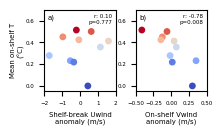

In [233]:
colors = np.linspace(0, 1, 10)
fs = 5

fig = plt.figure()
fig.set_size_inches(2.2,1.2)

ax = fig.add_subplot(1,2,1)
s0 = ax.scatter(sb_uwind_anoms_ordered, ens_shelf_T_ordered, c=color_vals, cmap='coolwarm_r',s=15)
r0, p_value0 = pearsonr(sb_uwind_anoms_ordered, ens_shelf_T_ordered)
ax.text(0.95, 0.95, 'r: {:.2f}'.format(r0)+'\np={:.3f}'.format(p_value0), transform=ax.transAxes,
        fontsize=fs-1, verticalalignment='top', horizontalalignment='right')

ax1 = fig.add_subplot(1,2,2)
s1 = ax1.scatter(shelf_vwinds_anoms_ordered, ens_shelf_T_ordered, c=color_vals, cmap='coolwarm_r',s=15)
r1, p_value1 = pearsonr(shelf_vwinds_anoms_ordered, ens_shelf_T_ordered)
ax1.text(0.95, 0.95, 'r: {:.2f}'.format(r1)+'\np={:.3f}'.format(p_value1), transform=ax1.transAxes,
         fontsize=fs-1, verticalalignment='top', horizontalalignment='right')

# format
ax.set_xlabel('Shelf-break Uwind\nanomaly (m/s)',fontsize=fs)
ax.set_ylabel('Mean on-shelf T\n(°C)',fontsize=fs,labelpad=1)
ax1.set_xlabel('On-shelf Vwind\nanomaly (m/s)',fontsize=fs)
# Add subplot labels
ax.text(0.15, 0.95, 'a)', transform=ax.transAxes,
        fontsize=fs, verticalalignment='top', horizontalalignment='right')
ax1.text(0.15, 0.95, 'b)', transform=ax1.transAxes,
         fontsize=fs, verticalalignment='top', horizontalalignment='right')
ax.set_xlim([-2,2])
ax1.set_xlim([-0.5,0.5])
for ax in [ax,ax1]:
    ax.tick_params(axis='both', which='major', labelsize=fs-1)
    ax.tick_params(axis='both', which='minor', labelsize=fs-1)
    ax.set_ylim([-0.05,0.7])
fig.subplots_adjust(wspace=0.28,left=0.2,bottom=0.3,top=0.98,right=0.94)

plt.savefig('Plots/Figure_5x_5yr_exp_scatter.png',dpi=600)